In [ ]:
import madpose
#import poselib

import json
import os

import cv2
import numpy as np

import madpose
from madpose.utils import compute_pose_error, get_depths

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

from romatch import roma_indoor

from transformers import (
    AutoModelForMaskGeneration,
    AutoProcessor,
    DepthProForDepthEstimation,
    DepthProImageProcessorFast,
    SamModel,
    SamProcessor,
    pipeline,
)

from ram.models import ram_plus, ram, tag2text

from ram import inference_ram as inference
from ram import get_transform

ImportError: cannot import name 'apply_chunking_to_forward' from 'transformers.modeling_utils' (/home/jovyan/miniconda3/envs/madpose/lib/python3.10/site-packages/transformers/modeling_utils.py)

In [2]:
# 1. Configure RANSAC options
options = madpose.HybridLORansacOptions()
options.min_num_iterations = 100
options.max_num_iterations = 1000
options.success_probability = 0.9999
options.random_seed = 0
options.final_least_squares = True
options.threshold_multiplier = 5.0
# Set reprojection (e.g., 4px) and epipolar error thresholds
options.squared_inlier_thresholds = [4.0**2, 4.0**2] 
options.data_type_weights = [1.0, 1.0]

# 2. Configure Estimator settings
est_config = madpose.EstimatorConfig()
est_config.min_depth_constraint = True # Ensures positive depth
est_config.use_shift = True            # Models depth shift
est_config.ceres_num_threads = 8       # Set to number of physical CPU cores

In [3]:
sample_path = "frames"
img_path0=os.path.join(sample_path, "frame_0053.png")
img_path1=os.path.join(sample_path, "frame_0116.png")

img0 = Image.open(img_path0)
img1 = Image.open(img_path1)
W_0, H_0 = img0.size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pp0 = (np.array(np.array(img0).shape[:2][::-1]) - 1) / 2
pp1 = (np.array(np.array(img1).shape[:2][::-1]) - 1) / 2
pp = pp0

In [4]:
# model ini

roma_model = roma_indoor(device="cuda")

depth_image_processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
depth_model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)

2026-01-05 06:26:49.622 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (864, 864)


In [5]:
def to_discrete_indices(kpts, W, H):
    """
    kpts: Tensor of shape (N, 2) containing (x, y) float coordinates
    W, H: Width and Height of the image
    """
    # 1. Round to nearest integer (gets the closest pixel center)
    coords = torch.round(kpts)
    
    # 2. Clamp values to valid image range [0, W-1] and [0, H-1]
    # This prevents crashing if RoMa predicts a point slightly off-screen
    x_coords = coords[:, 0].clamp(min=0, max=W-1)
    y_coords = coords[:, 1].clamp(min=0, max=H-1)
    
    # 3. Convert to Long (Integer) for indexing
    x_int = x_coords.long()
    y_int = y_coords.long()
    
    return x_int.cpu().numpy(), y_int.cpu().numpy()

def depth_single_frame(image):
    inputs = depth_image_processor(images=[image], return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = depth_model(**inputs)
    
    post_processed_output = depth_image_processor.post_process_depth_estimation(
        outputs, target_sizes=[(image.height, image.width)],
    )
    
    field_of_view = post_processed_output[0]["field_of_view"]
    print(field_of_view)
    focal_length = post_processed_output[0]["focal_length"]
    depth = post_processed_output[0]["predicted_depth"].detach().cpu().numpy()
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min())
    depth_norm = depth_norm * 255.
    depth_norm = depth_norm
    depth_norm = Image.fromarray(depth_norm.astype("uint8"))
    return depth, focal_length

In [6]:
#matching
warp, certainty = roma_model.match(img_path0, img_path1, device="cuda")
# Sample matches for estimation
matches, certainty = roma_model.sample(warp, certainty)


mkpts0, mkpts1 = roma_model.to_pixel_coordinates(matches, W_0, H_0 , W_0, H_0 )
mkpts0_x, mkpts0_y = to_discrete_indices(mkpts0, W_0, H_0)
mkpts1_x, mkpts1_y = to_discrete_indices(mkpts1, W_0, H_0)

# Move to CPU/Numpy for plotting
mkpts0 = mkpts0.cpu().numpy()
mkpts1 = mkpts1.cpu().numpy()


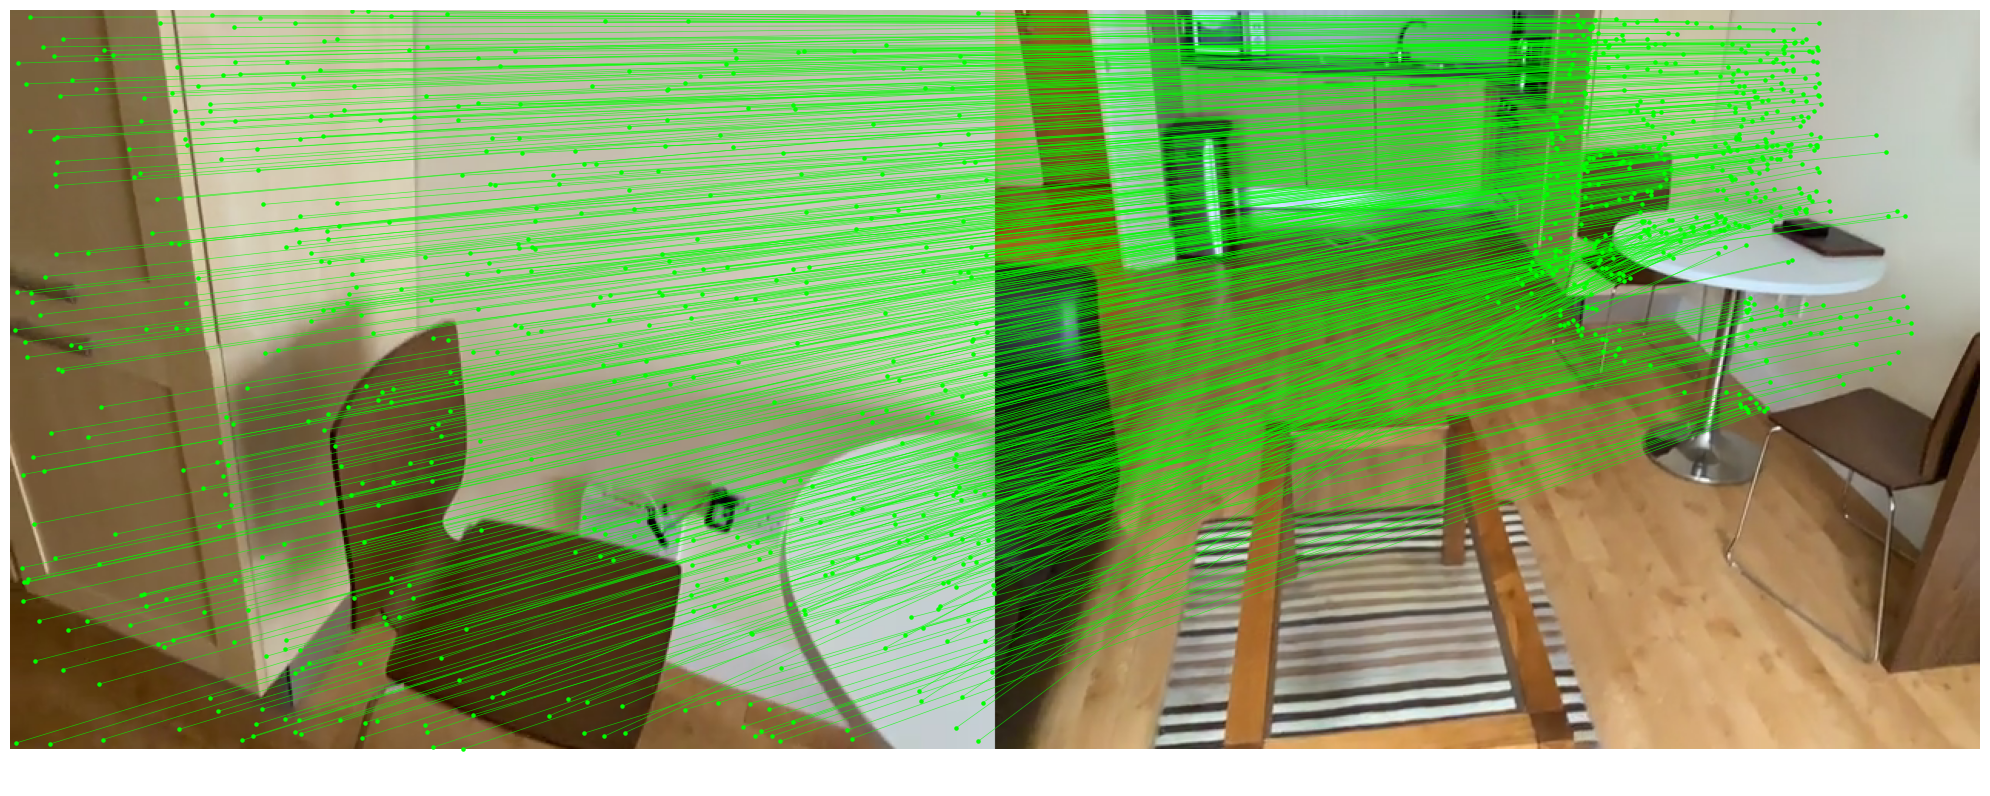

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def visualize_roma_matches(imA_path, imB_path, matches, roma_model):
    # 1. Load images to get dimensions
    imA = Image.open(imA_path)
    imB = Image.open(imB_path)
    W_A, H_A = imA.size
    W_B, H_B = imB.size

    # 2. Convert normalized matches [-1, 1] to pixel coordinates
    # RoMa's to_pixel_coordinates handles the math for you
    kptsA, kptsB = roma_model.to_pixel_coordinates(matches, H_A, W_A, H_B, W_B)

    # Move to CPU/Numpy for plotting
    kptsA = kptsA.cpu().numpy()
    kptsB = kptsB.cpu().numpy()

    # 3. Create the plot
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Concatenate images side-by-side
    imA_np = np.array(imA)
    imB_np = np.array(imB)
    
    # Handle different heights by padding (optional, but good for robustness)
    hA, wA, c = imA_np.shape
    hB, wB, c = imB_np.shape
    max_h = max(hA, hB)
    
    # Create canvas
    canvas = np.zeros((max_h, wA + wB, 3), dtype=np.uint8)
    canvas[:hA, :wA, :] = imA_np
    canvas[:hB, wA:wA+wB, :] = imB_np
    
    ax.imshow(canvas)
    ax.axis('off')

    # 4. Draw matches
    # Shift kptsB x-coordinates by width of image A
    kptsB_shifted = kptsB.copy()
    kptsB_shifted[:, 0] += wA

    # Plot lines
    # Using a random subset if there are too many matches to see clearly
    num_to_plot = min(len(kptsA), 500) 
    indices = np.random.choice(len(kptsA), num_to_plot, replace=False)

    for i in indices:
        # Draw line
        ax.plot([kptsA[i, 0], kptsB_shifted[i, 0]], 
                [kptsA[i, 1], kptsB_shifted[i, 1]], 
                c='lime', linewidth=0.5, alpha=0.7)
        
        # Draw dots
        ax.scatter(kptsA[i, 0], kptsA[i, 1], c='lime', s=5)
        ax.scatter(kptsB_shifted[i, 0], kptsB_shifted[i, 1], c='lime', s=5)

    plt.tight_layout()
    plt.show()

# --- USAGE ---
# Assuming you already ran:
# matches, certainty = roma_model.sample(warp, certainty)

visualize_roma_matches(img_path0, img_path1, matches, roma_model)

In [8]:
depth0, focal_length0=depth_single_frame(img0)
depth1, focal_length1=depth_single_frame(img1)

tensor(47.7189, device='cuda:0')
tensor(48.9413, device='cuda:0')


In [9]:
# Run hybrid estimation


pose, stats = madpose.HybridEstimatePoseScaleOffsetSharedFocal(
    mkpts0,
    mkpts1,
    depth0[mkpts0_y,mkpts0_x],
    depth1[mkpts1_y,mkpts1_x],
    [depth0.min(), depth1.min()],
    pp0,
    pp1,
    options,
    est_config,
)
# rotation and translation of the estimated pose
R_est, t_est = pose.R(), pose.t()
# scale and offsets of the affine corrected depth maps
s_est, o0_est, o1_est = pose.scale, pose.offset0, pose.offset1
# estimated shared focal length
f_est = pose.focal



In [10]:
f0_est, f1_est 

NameError: name 'f0_est' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_point_cloud(depth, K, step=5):
    """
    Backproject depth map to 3D point cloud.
    step: Downsampling factor for faster visualization.
    """
    H, W = depth.shape
    # Create grid of coordinates
    y, x = np.meshgrid(np.arange(0, H, step), np.arange(0, W, step), indexing='ij')
    x = x.flatten()
    y = y.flatten()
    z = depth[::step, ::step].flatten()
    
    # Filter out invalid depth
    valid = (z > 0)
    x, y, z = x[valid], y[valid], z[valid]
    
    # Backproject using intrinsics: X = (u - cx) * Z / fx
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    x_3d = (x - cx) * z / fx
    y_3d = (y - cy) * z / fy
    z_3d = z
    
    return np.stack([x_3d, y_3d, z_3d], axis=1)

# 1. Construct the Intrinsic Matrix K using estimated focal length
# Note: We assume the principal point is at the image center (pp0 from your code)
K_est = np.eye(3)
K_est[0, 0] = f_est
K_est[1, 1] = f_est
K_est[0, 2] = pp0[0]
K_est[1, 2] = pp0[1]

# 2. OPTIONAL: Apply Scale/Offset corrections
# MadPose estimates affine parameters (s, o0, o1) to align prediction to metric.
# If your alignment looks poor, uncomment the lines below to apply the estimated affine correction.
# d0_vis = s_est * depth0 + o0_est
# d1_vis = s_est * depth1 + o1_est
d0_vis = depth0
d1_vis = depth1

# 3. Generate Point Clouds
pts0 = get_point_cloud(d0_vis, K_est, step=6) # Cloud 0 (Target)
pts1 = get_point_cloud(d1_vis, K_est, step=6) # Cloud 1 (Source)

# 4. Transform Cloud 1 using estimated R and t
# Formula: P_0 = R * P_1 + t
pts1_transformed = (R_est @ pts1.T).T + t_est

# 5. Visualization
fig = plt.figure(figsize=(14, 7))

# Plot 1: Untransformed (Local Coordinates)
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pts0[:, 0], pts0[:, 2], pts0[:, 1], s=0.5, c='blue', alpha=0.5, label='View 0')
ax1.scatter(pts1[:, 0], pts1[:, 2], pts1[:, 1], s=0.5, c='red', alpha=0.5, label='View 1')
ax1.set_title("Untransformed (Local Coords)")
ax1.set_xlabel('X')
ax1.set_ylabel('Z (Depth)')
ax1.set_zlabel('Y')
# Invert Y/Z axes for better "world" viewing if needed
ax1.invert_zaxis() 
ax1.legend()

# Plot 2: Transformed (Aligned)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(pts0[:, 0], pts0[:, 2], pts0[:, 1], s=0.5, c='blue', alpha=0.5, label='View 0')
ax2.scatter(pts1_transformed[:, 0], pts1_transformed[:, 2], pts1_transformed[:, 1], s=0.5, c='red', alpha=0.5, label='View 1 (Aligned)')
ax2.set_title("Transformed (Aligned)")
ax2.set_xlabel('X')
ax2.set_ylabel('Z (Depth)')
ax2.set_zlabel('Y')
ax2.invert_zaxis()
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
mkpts1_x.max()

In [ ]:
mkpts1_y.max()

In [ ]:
def dedup_grounding_boxes(grounding_result, iou_thresh=0.8):
    """Merge near-duplicate boxes using IoU (higher-score label kept)."""
    def iou_xyxy(b1, b2):
        xA = max(b1['xmin'], b2['xmin'])
        yA = max(b1['ymin'], b2['ymin'])
        xB = min(b1['xmax'], b2['xmax'])
        yB = min(b1['ymax'], b2['ymax'])
        inter_w = max(0, xB - xA)
        inter_h = max(0, yB - yA)
        inter = inter_w * inter_h
        area1 = (b1['xmax'] - b1['xmin']) * (b1['ymax'] - b1['ymin'])
        area2 = (b2['xmax'] - b2['xmin']) * (b2['ymax'] - b2['ymin'])
        union = area1 + area2 - inter
        return inter / union if union > 0 else 0.0

    # Sort high to low so we keep the best scoring label in each cluster
    detections = sorted(grounding_result, key=lambda d: d['score'], reverse=True)
    filtered = []
    for det in detections:
        if all(iou_xyxy(det['box'], kept['box']) <= iou_thresh for kept in filtered):
            filtered.append(det)
    return filtered

filtered_grounding_result = dedup_grounding_boxes(grounding_result, iou_thresh=0.8)

# Use the filtered list for visualization (replace with your plot function)
# show_grounding(img0, filtered_grounding_result)
